<a href="https://colab.research.google.com/github/Alton01/FashionMNIST_computer_vision_pytorch/blob/main/computer_vision_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt


In [ ]:
train_data = datasets.FashionMNIST(
    root="data", # where data is to be downloaded to
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data", # where data is to be downloaded to
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 24.7MB/s]


In [ ]:
len(train_data), len(test_data)

(60000, 10000)

image shape: torch.Size([1, 28, 28]), label: 9


Text(0.5, 1.0, '9')

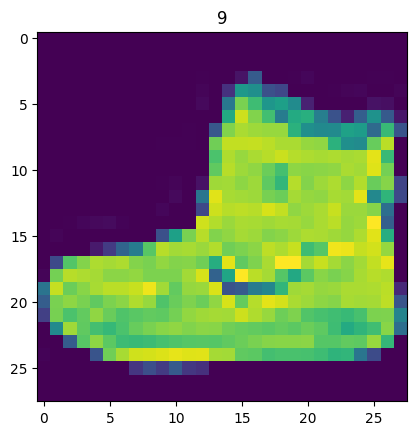

In [ ]:
image, label = train_data[0]
print(f"image shape: {image.shape}, label: {label}")

plt.imshow(image.squeeze())
plt.title(label)

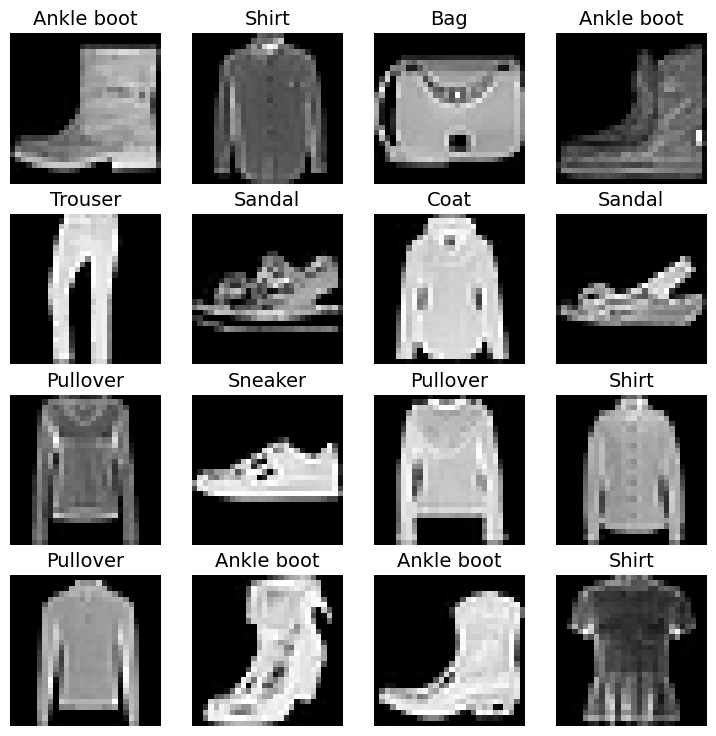

In [ ]:
#visualizing the data
class_names = train_data.classes
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9)) #creates a square figure with both width and height set to 9 inches.
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item() # select a random image
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray") # we squeeze to avoid problems with matplotlib by removing any 1 extra dimension
    plt.title(class_names[label], fontsize=14)
    plt.axis(False)

In [ ]:
# Dataloader batchifies our data due to compute memory.
# it also gives our neural network more chances to update its gradient per epoch. at 32 images per batch instead of 60,000 images.
# our neural network updates its weight every 32 images thanks to the optimizer.

from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c42c091b1d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c42c05e0190>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [ ]:
#structure of train_loader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

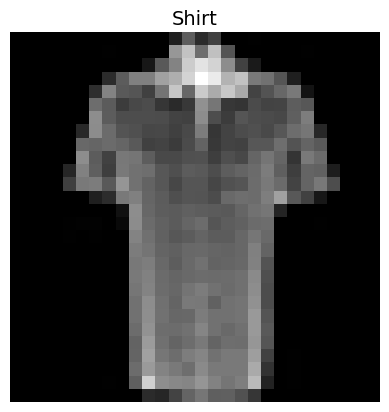

In [ ]:
# show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label], fontsize=14)
plt.axis(False)

In [ ]:
flatten_model = nn.Flatten() # flattens a contiguous range of dims into a 1D input tensor/vector. For use with sequential()
# condensing information down into a single vector space because we are also using a linear layer in the model
#  which cant handle multi dimensional data so we condense it into a single vector as input.
x = train_features_batch[0]

output = flatten_model(x)
print(f"Shape before flattening: {x.shape}")
print(f"Shape after flattening: {output.shape}")

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [ ]:
# A larger number of hidden units can allow the model to learn more complex patterns
# but also increases the risk of overfitting and requires more computational resources.
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__() # calls the constructor of the parent class (nn.Module), which is necessary for proper initialization.
    self.layer_stack = nn.Sequential(
      nn.Flatten(), # flattens contiguous range of dims (width $ height) into a 1D data/tensor for nn.linear to be able to work on it.
      nn.Linear(in_features=input_shape, out_features=hidden_units),
      nn.Linear(in_features=hidden_units, out_features=output_shape),
    )

  def forward(self, x):
    return self.layer_stack(x)


In [ ]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
import requests

from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [ ]:
# loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [ ]:
# function for timing our experiments

from timeit import default_timer as timer # measures execution time of code

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
start_time = timer()
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 seconds


2.7420999998639672e-05

In [ ]:
# tqdm for progress bar

from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")

    #Training
    train_loss = 0
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()

        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad() # clears gradients of model's parameters otherwise gradients from previous batches would accumulate.

        loss.backward() # calculates gradients of the loss with respect to the model's parameters

        optimizer.step() # updates the model's parameters based on the calculated gradients

        if batch % 400 == 0:
          print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    train_loss /= len(train_dataloader
    )

    # TESTING
    test_loss, test_acc = 0, 0
    model_0.eval()

    with torch.inference_mode():
      for X_test, y_test in test_dataloader:

        test_pred = model_0(X_test) #output in logits

        test_loss += loss_fn(test_pred, y_test)

        test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1)) #use argmax to convert highest logit to label.

      # calculate test loss average per batch
      test_loss /= len(test_dataloader)

      # calculate test accuracy average per batch
      test_acc /= len(test_dataloader)


    print(f"\n Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# make predictions and get Model 0 results

torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device): # Add device parameter here
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:

      X, y = X.to(device), y.to(device)


      y_pred = model(X)   # raw outputs are in logits

      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    # Getting the average loss and accuracy per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # to track models by different class names.
          "model_loss": loss.item(),
          "model_acc": acc}

model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device="cpu") # Pass the device here
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# creating a model with non-linear and linear layers.

class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                             hidden_units=10,
                             output_shape=len(class_names)).to(device)
model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [ ]:
# Functionizing training loops


def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

    train_loss, train_acc = 0, 0

    model.train()

    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(data_loader):

        X, y = X.to(device), y.to(device)

        y_pred = model(X) # outputs  in logits

        loss = loss_fn(y_pred, y)

        train_loss += loss

        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad() # clears gradients of model's parameters otherwise gradients from previous batches would accumulate.

        loss.backward() # calculates gradients of the loss with respect to the model's parameters

        optimizer.step() # updates the model's parameters based on the calculated gradients

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.3f}%")

    return {"train_loss": train_loss.item(),
            "train_acc": train_acc}



In [ ]:
# Functionizing evaluation/testing loops

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

  test_loss, test_acc = 0, 0

  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:

      X, y = X.to(device), y.to(device)

      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)

      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.3f}%")

    return {"test_loss": test_loss.item(),
            "test_acc": test_acc}

In [ ]:
torch.manual_seed(42)

from timeit import default_timer as timer

train_time_start_on_gpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")

  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)


  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_on_cpu = timer()

total_train_time_model_1 = print_train_time(start=train_time_start_on_cpu, end=train_time_end_on_cpu,
                                            device=device)



In [ ]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [ ]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [ ]:
# Building a Convolutional Neural Network
# Architecture replicates TinyVGG


class FashionMNISTModelV2(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    # Feature Extractor Layer 1
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3, # This defines size & shape of convolutional kernel (or filter) as it passes over the input. A 3x3 kernel is used here.
                  stride=1, # Determines number of step a filter/kernel takes across an image at a time. A stride of 1 means the kernel moves one pixel at a time.
                  padding=1), # This adds zero-padding to the input image. Padding of 1 means one layer of zeros is added around the input,
         # which helps to preserve the input shape (spatial dimensions of the output feature maps).
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2) # really compresses the features
    )

    # Feature Extractor Layer 2
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3, # This defines size & shape of convolutional kernel (or filter) as it passes over the input. A 3x3 kernel is used here.
                  stride=1, # Determines number of step a filter/kernel takes across an image at a time. A stride of 1 means the kernel moves one pixel at a time.
                  padding=1), # This adds zero-padding to the input image. Padding of 1 means one layer of zeros is added around the input,
                  # which helps to preserve the input shape (spatial dimensions of the output feature maps).
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    # Feature Extractor Layer compresses learned features into 1D Vector and passes it through classifier layer for it to be classified
    # Classifier Layer

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )


  def forward(self, x):
      x = self.conv_block_1(x)
   #  print(f"Output shape of conv_block_1: {x.shape}")
      x = self.conv_block_2(x)
   #  print(f"Output shape of conv_block_2: {x.shape}")
      x = self.classifier(x)
   #  print(f"Output shape of classifier: {x.shape}")
      return x

In [ ]:
torch.manual_seed(42)

model_2 = FashionMNISTModelV2(input_shape=1,
                             hidden_units=10,
                             output_shape=len(class_names)).to(device)

In [ ]:
# Test for calculating number of input_features to be passed to linear layer in self.classifier above for CNN MODEL.
# generate random image tensor
rand_image_tensor = torch.randn(size=(1, 28, 28))
rand_image_tensor.shape


torch.Size([1, 28, 28])

In [ ]:
# Test for calculating number of input_features to be passed to linear layer in self.classifier above for CNN MODEL.
# Pass image through model
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 2.8786, -0.1069, -0.9256,  2.4242,  0.5976,  0.1297,  3.9138, -6.3534,
         -1.0823, -0.8810]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
# Test for calculating number of input_features to be passed to linear layer in self.classifier above for CNN MODEL.
torch.manual_seed(42)

# create a batch of images

images = torch.randn(size=(32, 3, 64, 64))

test_image = images[0]

print(f" Image batch shape: {images.shape}")
print(f" Single Image shape: {test_image.shape}")
print(f"Test image:\n {test_image}")

 Image batch shape: torch.Size([32, 3, 64, 64])
 Single Image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[

In [ ]:
# Test for calculating number of input_features to be passed to linear layer in self.classifier above for CNN MODEL.
# Create a  single conv2d layer
torch.manual_seed(42)

conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)

conv_output = conv_layer(test_image.unsqueeze(dim=0))

conv_output.shape

torch.Size([1, 10, 62, 62])

In [ ]:
# Test for calculating number of input_features to be passed to linear layer in self.classifier above for CNN MODEL.
test_image.shape

torch.Size([3, 64, 64])

In [ ]:
# Test for calculating number of input_features to be passed to linear layer in self.classifier above for CNN MODEL.
# Print out original image shape without unsqueezed image dimension

print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(0).shape}")

#create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer

test_image_through_conv = conv_layer(test_image.unsqueeze(0))
print(f"Test image through conv_layer shape: {test_image_through_conv.shape}")

# pass data through maxpool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Test image through conv_layer and max_pool_layer shape: {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Test image through conv_layer shape: torch.Size([1, 10, 62, 62])
Test image through conv_layer and max_pool_layer shape: torch.Size([1, 10, 31, 31])


In [ ]:
# Test for calculating number of input_features to be passed to linear layer in self.classifier above for CNN MODEL.
torch.manual_seed(42)

# Create a  random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass the random tensor through the max pooling layer
max_pool_tensor = max_pool_layer(random_tensor)

print(f"Random tensor: \n {random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")
print(f"Max pool tensor: \n {max_pool_tensor}")
print(f"Max pool tensor shape: \n {max_pool_tensor.shape}")



Random tensor: 
 tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])
Max pool tensor: 
 tensor([[[[0.3367]]]])
Max pool tensor shape: 
 torch.Size([1, 1, 1, 1])


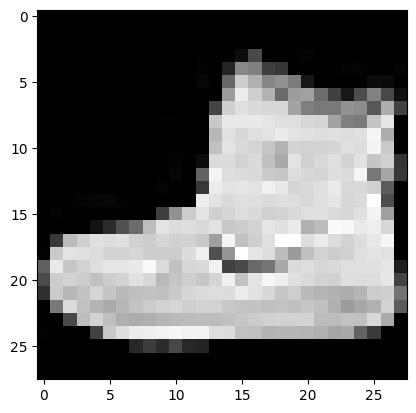

In [ ]:
# Test for calculating number of input_features to be passed to linear layer in self.classifier above for CNN MODEL.

plt.imshow(image.squeeze(), cmap='gray')

In [ ]:
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 2.8786, -0.1069, -0.9256,  2.4242,  0.5976,  0.1297,  3.9138, -6.3534,
         -1.0823, -0.8810]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
# Setup loss function, eval metrics and optimizer for model 2

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [ ]:
#model 2 parameters
model_2.state_dict()

In [ ]:
# Training and testing model 2 using train and test functions

torch.manual_seed(42)
torch.cuda.manual_seed(42)

#measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and Test Model
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")

  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2, end=train_time_end_model_2,
                                            device=device)

In [ ]:
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.30255135893821716,
 'model_acc': 89.1673322683706}

In [ ]:
#compare model results and training time

import pandas as pd
compare_results = pd.DataFrame(data=[model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.302551,89.167332


In [ ]:
# compare training time across  models
# add a new column of training time to compare results dataframe.
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,27.551950
1,FashionMNISTModelV1,0.685001,75.019968,60.150005
2,FashionMNISTModelV2,0.302551,89.167332,37.357475


Text(0, 0.5, 'model')

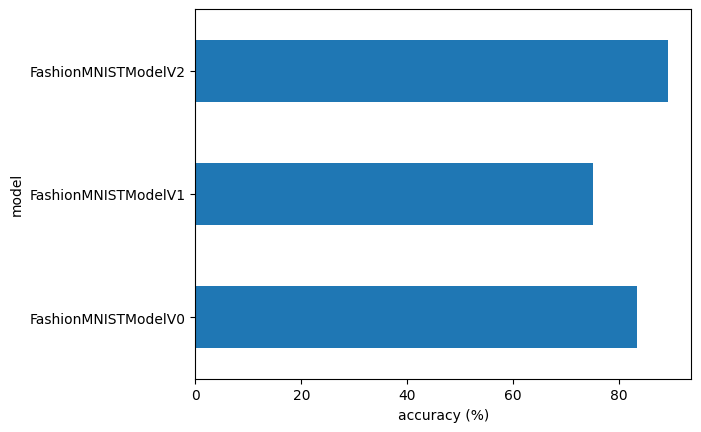

In [ ]:
# Visualize model results

compare_results.set_index("model_name")["model_acc"].plot(kind="barh") # barh = horizontal  bar chart
plt.xlabel("accuracy (%)")
plt.ylabel("model")

In [ ]:
# Make and evaluate random predictions with the best model

def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):

  pred_probs = []
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for sample in data:

      # Prepare the sample( add a batch dimension and pass to target device)
      # Prepares the sample for the model by adding a batch dimension (models usually expect input in batches) and moving it to the specified device.
      sample = torch.unsqueeze(sample, dim=0).to(device)

      pred_logit = model(sample) # comes in logits because we have a linear layer at the end of our model

      # convert from logits to prediction probability via softmax and removes the added batch dimension.
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu()) # make sure ur data is  on cpu bcos matplotlib does not work on gpu.

  # Stack the pred_probs to turn list into a tensor
  # Stacks the list of prediction probability tensors into a single tensor and returns it.
  return torch.stack(pred_probs)

In [ ]:
import random
#random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9): # randomly sampling 9 samples.
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Bag')

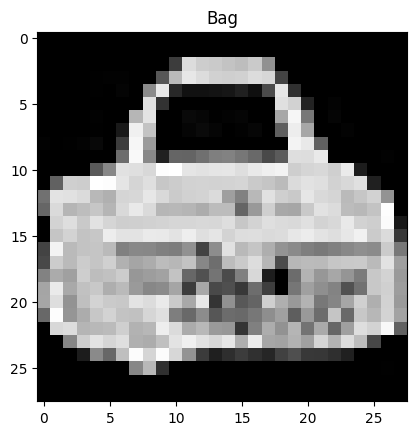

In [ ]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [ ]:
# Make Predictions

pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# View first two prediction probabilities
pred_probs[:2]

tensor([[1.9937e-03, 2.2508e-06, 4.1837e-04, 1.6256e-04, 7.5723e-04, 1.1493e-04,
         7.6339e-04, 2.9672e-03, 9.9278e-01, 4.0249e-05],
        [8.7606e-01, 1.6915e-04, 6.8902e-02, 1.8955e-03, 1.1965e-03, 1.4949e-06,
         4.4757e-02, 1.0800e-06, 7.0164e-03, 1.6839e-06]])

In [ ]:
# convert prediction probabilities to labels

pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([8, 0, 3, 7, 2, 9, 2, 6, 0])

In [ ]:
test_labels

[8, 0, 6, 7, 2, 9, 2, 6, 0]

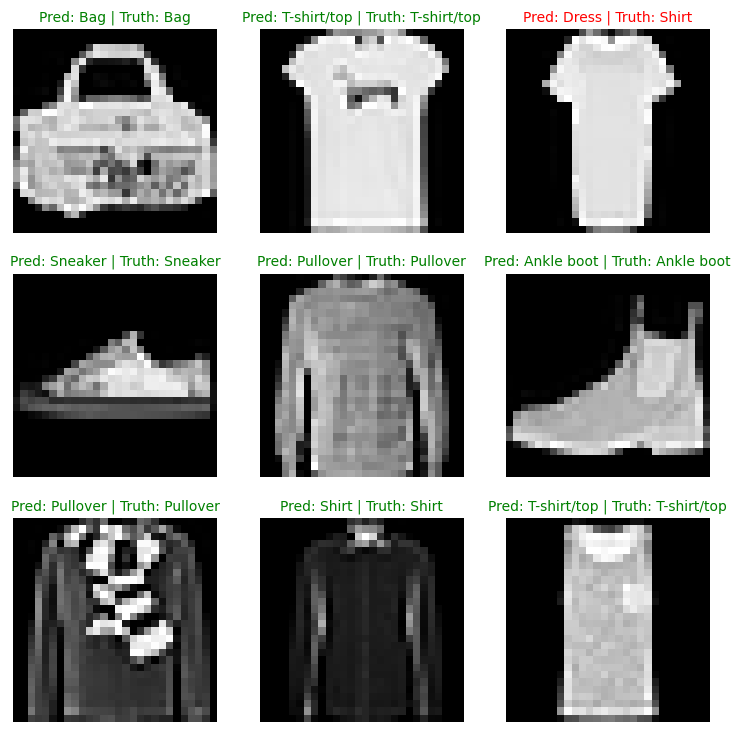

In [ ]:
# Plot Predictions

plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):

  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Get the prediction in text form
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form)
  truth_label = class_names[test_labels[i]]

  # Create a title text for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change the color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

  # Remove the axis ticks
  plt.axis("off")

In [ ]:
# Making predictions across whole test dataset and importing libraries to plot confusion matrix.
# A confusion matrix is a fantastic way of evaluating your classification models visually.

In [ ]:
# make predictions with trained model

y_preds = []

model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making Predictions...."):

    X, y = X.to(device), y.to(device)

    y_logit = model_2(X)

    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)

    y_preds.append(y_pred.cpu())

  # Concatenate list of predictions into a tensor
  # print(y_preds)
  y_pred_tensor = torch.cat(y_preds)
  y_pred_tensor

In [ ]:
# see if required packages are installed and if not, install them.

try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "ml version outdated"
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend

  print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.4


In [ ]:
test_data.targets

tensor([9, 2, 1,  ..., 8, 1, 5])

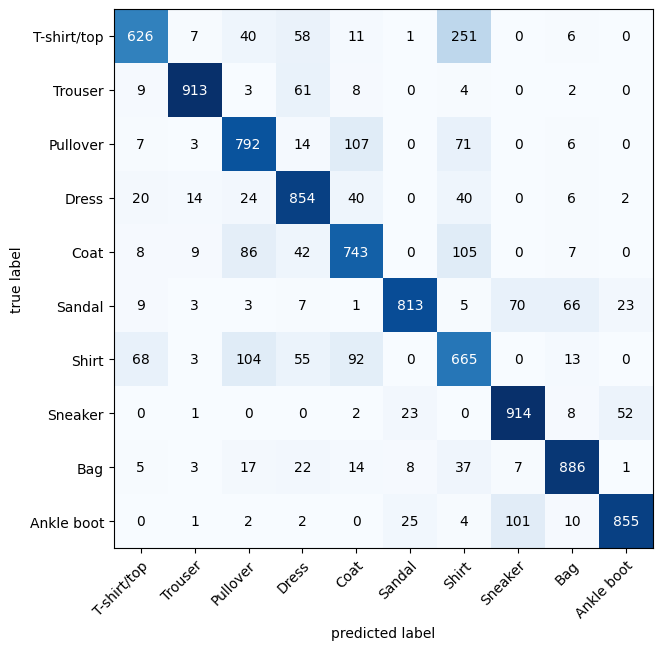

In [ ]:
# use confusion matrix to compare predictions to target labels in our dataset.

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# set up an instance of confusion matrix and compare predictions to targets
confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

#Plot the confusion matrix

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), # matplotlib likes workng with numpy
                                class_names=class_names,
                                figsize=(10, 7))

In [ ]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # state dict refers to model_2's parameters ( weight and biases )
           f=MODEL_SAVE_PATH)


Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [ ]:
#create a new instance of model 2

torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_names))

#load the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_2.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.30255135893821716,
 'model_acc': 89.1673322683706}

In [ ]:
# Evaluate loaded model

torch.manual_seed(42)
loaded_model_2_results = eval_model(model=loaded_model_2,
                                   data_loader=test_dataloader,
                                   loss_fn=loss_fn,
                                   accuracy_fn=accuracy_fn,
                                   device=device)

loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.30255135893821716,
 'model_acc': 89.1673322683706}